In this notebook i will follow the instructions in this video and adapt based on or proect and preferences : https://www.youtube.com/watch?v=p_6kULimQvI

In [1]:
pip install --upgrade matplotlib


                                              0.0/7.5 MB ? eta -:--:--
                                              0.0/7.5 MB 991.0 kB/s eta 0:00:08
                                              0.1/7.5 MB 919.0 kB/s eta 0:00:09
                                              0.1/7.5 MB 1.1 MB/s eta 0:00:07
     -                                        0.2/7.5 MB 1.2 MB/s eta 0:00:07
     -                                        0.3/7.5 MB 1.3 MB/s eta 0:00:06
     --                                       0.4/7.5 MB 1.4 MB/s eta 0:00:05
     --                                       0.4/7.5 MB 1.4 MB/s eta 0:00:06
     --                                       0.5/7.5 MB 1.2 MB/s eta 0:00:06
     --                                       0.5/7.5 MB 1.2 MB/s eta 0:00:06
     --                                       0.5/7.5 MB 1.0 MB/s eta 0:00:07
     --                                       0.5/7.5 MB 1.0 MB/s eta 0:00:07
     ---                                      0.6/7.5 MB 1.0 MB/s 

In [2]:
pip install numpy scipy

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importing the libraries
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import GRU, Dense

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error


from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt


In [4]:
# root_path = '../input/cs.csv' # local file
root_path = '..\cleaned-data\ethereum-pools-volume-cleaned.csv'

In [5]:
stock_df = pd.read_csv(root_path)
stock_df.head()

,daily_volume,time,total_volume,Pool-Name,running_total_by_pool
0,8.568270e+04,2021-05-05T00:00:00+00:00,8.568270e+04,DAI / ETH 0.05% fee,8.568270e+04
1,1.431467e+06,2021-05-06T00:00:00+00:00,1.517149e+06,DAI / ETH 0.05% fee,1.517149e+06
2,8.459799e+06,2021-05-07T00:00:00+00:00,9.976948e+06,DAI / ETH 0.05% fee,9.976948e+06
3,6.341874e+06,2021-05-08T00:00:00+00:00,1.631882e+07,DAI / ETH 0.05% fee,1.631882e+07
4,2.707201e+05,2021-05-09T00:00:00+00:00,1.658954e+07,DAI / ETH 0.05% fee,1.658954e+07


In [6]:
stock_df = stock_df.rename(columns={'Pool-Name': 'pool_name'})
stock_df.head()

,daily_volume,time,total_volume,pool_name,running_total_by_pool
0,8.568270e+04,2021-05-05T00:00:00+00:00,8.568270e+04,DAI / ETH 0.05% fee,8.568270e+04
1,1.431467e+06,2021-05-06T00:00:00+00:00,1.517149e+06,DAI / ETH 0.05% fee,1.517149e+06
2,8.459799e+06,2021-05-07T00:00:00+00:00,9.976948e+06,DAI / ETH 0.05% fee,9.976948e+06
3,6.341874e+06,2021-05-08T00:00:00+00:00,1.631882e+07,DAI / ETH 0.05% fee,1.631882e+07
4,2.707201e+05,2021-05-09T00:00:00+00:00,1.658954e+07,DAI / ETH 0.05% fee,1.658954e+07


In [7]:
# Loading the data
dataset = pd.read_csv('..\cleaned-data\ethereum-pools-volume-cleaned.csv')

In [8]:
# Split column 'Pool-Name' into three columns: 'Token_1', 'Token_2' and 'Fee's'
crypto_info = dataset['Pool-Name'].str.split(' ', n=2, expand=True)
dataset['Token_1'] = crypto_info[0]
dataset['Token_2'] = crypto_info[2].str.split(' ', n=1, expand=True)[0]

# Create columns for each rate type
dataset['fee_0.01%'] = 0
dataset['fee_0.05%'] = 0
dataset['fee_0.3%'] = 0
dataset['fee_1%'] = 0

# Assign the correct values to the fee columns
dataset.loc[dataset['Pool-Name'].str.contains('0.01%'), 'fee_0.01%'] = 1
dataset.loc[dataset['Pool-Name'].str.contains('0.05%'), 'fee_0.05%'] = 1
dataset.loc[dataset['Pool-Name'].str.contains('0.3%'), 'fee_0.3%'] = 1
dataset.loc[dataset['Pool-Name'].str.contains('1%'), 'fee_1%'] = 1

# printing to see the results
dataset

,daily_volume,time,total_volume,Pool-Name,running_total_by_pool,Token_1,Token_2,fee_0.01%,fee_0.05%,fee_0.3%,fee_1%
0,8.568270e+04,2021-05-05T00:00:00+00:00,8.568270e+04,DAI / ETH 0.05% fee,8.568270e+04,DAI,ETH,0,1,0,0
1,1.431467e+06,2021-05-06T00:00:00+00:00,1.517149e+06,DAI / ETH 0.05% fee,1.517149e+06,DAI,ETH,0,1,0,0
2,8.459799e+06,2021-05-07T00:00:00+00:00,9.976948e+06,DAI / ETH 0.05% fee,9.976948e+06,DAI,ETH,0,1,0,0
3,6.341874e+06,2021-05-08T00:00:00+00:00,1.631882e+07,DAI / ETH 0.05% fee,1.631882e+07,DAI,ETH,0,1,0,0
4,2.707201e+05,2021-05-09T00:00:00+00:00,1.658954e+07,DAI / ETH 0.05% fee,1.658954e+07,DAI,ETH,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
15043,1.432193e+08,2023-05-22T00:00:00+00:00,3.750031e+11,ETH / USDC 0.05% fee,3.750031e+11,ETH,USDC,0,1,0,0
15044,1.514438e+08,2023-05-23T00:00:00+00:00,3.751546e+11,ETH / USDC 0.05% fee,3.751546e+11,ETH,USDC,0,1,0,0
15045,1.956226e+08,2023-05-24T00:00:00+00:00,3.753502e+11,ETH / USDC 0.05% fee,3.753502e+11,ETH,USDC,0,1,0,0
15046,1.432230e+08,2023-05-25T00:00:00+00:00,3.754934e+11,ETH / USDC 0.05% fee,3.754934e+11,ETH,USDC,0,1,0,0


In [9]:
# Save the new DataFrame to a CSV file
dataset.to_csv('new_dataset.csv', index=False)

In [10]:
# Token-to-number mapping dictionary
token_dict = {'DAI': 0, 'ETH': 1, 'LUSD': 2, 'USDC': 3, 'UDT': 4, 'MATIC': 5, 'WBTC': 6, 'USDT': 7, 'LINK': 8, 'OP': 9, 'ARB': 10, 'WETH': 11, 'BUSD': 12, 'BNB': 13}

# Mapping tokens to numbers in column 'Token_1'
dataset['Token_1'] = dataset['Token_1'].map(token_dict)

# Mapping tokens to numbers in column 'Token_2'
dataset['Token_2'] = dataset['Token_2'].map(token_dict)

dataset


,daily_volume,time,total_volume,Pool-Name,running_total_by_pool,Token_1,Token_2,fee_0.01%,fee_0.05%,fee_0.3%,fee_1%
0,8.568270e+04,2021-05-05T00:00:00+00:00,8.568270e+04,DAI / ETH 0.05% fee,8.568270e+04,0,1,0,1,0,0
1,1.431467e+06,2021-05-06T00:00:00+00:00,1.517149e+06,DAI / ETH 0.05% fee,1.517149e+06,0,1,0,1,0,0
2,8.459799e+06,2021-05-07T00:00:00+00:00,9.976948e+06,DAI / ETH 0.05% fee,9.976948e+06,0,1,0,1,0,0
3,6.341874e+06,2021-05-08T00:00:00+00:00,1.631882e+07,DAI / ETH 0.05% fee,1.631882e+07,0,1,0,1,0,0
4,2.707201e+05,2021-05-09T00:00:00+00:00,1.658954e+07,DAI / ETH 0.05% fee,1.658954e+07,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
15043,1.432193e+08,2023-05-22T00:00:00+00:00,3.750031e+11,ETH / USDC 0.05% fee,3.750031e+11,1,3,0,1,0,0
15044,1.514438e+08,2023-05-23T00:00:00+00:00,3.751546e+11,ETH / USDC 0.05% fee,3.751546e+11,1,3,0,1,0,0
15045,1.956226e+08,2023-05-24T00:00:00+00:00,3.753502e+11,ETH / USDC 0.05% fee,3.753502e+11,1,3,0,1,0,0
15046,1.432230e+08,2023-05-25T00:00:00+00:00,3.754934e+11,ETH / USDC 0.05% fee,3.754934e+11,1,3,0,1,0,0


In [11]:
# Removing the column 'Pool-Name' because the infos are now splited
dataset = dataset.drop(columns=['Pool-Name'])
dataset

,daily_volume,time,total_volume,running_total_by_pool,Token_1,Token_2,fee_0.01%,fee_0.05%,fee_0.3%,fee_1%
0,8.568270e+04,2021-05-05T00:00:00+00:00,8.568270e+04,8.568270e+04,0,1,0,1,0,0
1,1.431467e+06,2021-05-06T00:00:00+00:00,1.517149e+06,1.517149e+06,0,1,0,1,0,0
2,8.459799e+06,2021-05-07T00:00:00+00:00,9.976948e+06,9.976948e+06,0,1,0,1,0,0
3,6.341874e+06,2021-05-08T00:00:00+00:00,1.631882e+07,1.631882e+07,0,1,0,1,0,0
4,2.707201e+05,2021-05-09T00:00:00+00:00,1.658954e+07,1.658954e+07,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
15043,1.432193e+08,2023-05-22T00:00:00+00:00,3.750031e+11,3.750031e+11,1,3,0,1,0,0
15044,1.514438e+08,2023-05-23T00:00:00+00:00,3.751546e+11,3.751546e+11,1,3,0,1,0,0
15045,1.956226e+08,2023-05-24T00:00:00+00:00,3.753502e+11,3.753502e+11,1,3,0,1,0,0
15046,1.432230e+08,2023-05-25T00:00:00+00:00,3.754934e+11,3.754934e+11,1,3,0,1,0,0


In [12]:
# Convert 'time' column to datetime format
dataset['time'] = pd.to_datetime(dataset['time'])

# Set 'time' column as the index of the DataFrame
dataset.set_index('time', inplace=True)
dataset

,daily_volume,total_volume,running_total_by_pool,Token_1,Token_2,fee_0.01%,fee_0.05%,fee_0.3%,fee_1%
time,,,,,,,,,
2021-05-05 00:00:00+00:00,8.568270e+04,8.568270e+04,8.568270e+04,0,1,0,1,0,0
2021-05-06 00:00:00+00:00,1.431467e+06,1.517149e+06,1.517149e+06,0,1,0,1,0,0
2021-05-07 00:00:00+00:00,8.459799e+06,9.976948e+06,9.976948e+06,0,1,0,1,0,0
2021-05-08 00:00:00+00:00,6.341874e+06,1.631882e+07,1.631882e+07,0,1,0,1,0,0
2021-05-09 00:00:00+00:00,2.707201e+05,1.658954e+07,1.658954e+07,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
2023-05-22 00:00:00+00:00,1.432193e+08,3.750031e+11,3.750031e+11,1,3,0,1,0,0
2023-05-23 00:00:00+00:00,1.514438e+08,3.751546e+11,3.751546e+11,1,3,0,1,0,0
2023-05-24 00:00:00+00:00,1.956226e+08,3.753502e+11,3.753502e+11,1,3,0,1,0,0


In [13]:
# Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Print the normalized data
print(scaled_data)

[[2.65789325e-05 2.28026061e-07 2.28026061e-07 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.44049152e-04 4.03908420e-06 4.03908420e-06 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.62427965e-03 2.65619867e-05 2.65619867e-05 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [6.06832882e-02 9.99311671e-01 9.99311671e-01 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.44286309e-02 9.99692980e-01 9.99692980e-01 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.57727157e-02 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [14]:
# Determine the split point for 80% of the data
split_point = int(len(scaled_data) * 0.6)

# Split the data into training and test sets
train, test = scaled_data[:split_point], scaled_data[split_point:]


# Print the number of items in each set
print('Training set: ', len(train))
print('Test set: ', len(test))

Training set:  9028
Test set:  6020


In [15]:
# Set the length of the sequence
seq_length = 10

# Function to create time sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create time sequences for training
X_train, y_train = create_sequences(train, seq_length)
# Create time sequences for testing
X_test, y_test = create_sequences(test, seq_length)

In [16]:
# Defines the GRU model
model = Sequential()
model.add(GRU(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(50, activation='relu'))
model.add(Dense(1))

# Compiles the template
model.compile(optimizer='adam', loss='mse')

# Displays the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 50)            9150      
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 24,501
Trainable params: 24,501
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)



# Get the model predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Adjust the dimensions of y_train and y_test
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


Epoch 1/100
141/141 [==============================] - 3s 8ms/step - loss: 0.1402
Epoch 2/100
141/141 [==============================] - 1s 8ms/step - loss: 0.1368
Epoch 3/100
141/141 [==============================] - 1s 8ms/step - loss: 0.1368
Epoch 4/100
141/141 [==============================] - 1s 8ms/step - loss: 0.1368
Epoch 5/100
141/141 [==============================] - 1s 8ms/step - loss: 0.1368
Epoch 6/100
141/141 [==============================] - 1s 8ms/step - loss: 0.1368
Epoch 7/100
141/141 [==============================] - 1s 8ms/step - loss: 0.1368
Epoch 8/100
141/141 [==============================] - 1s 8ms/step - loss: 0.1368
Epoch 9/100
141/141 [==============================] - 1s 8ms/step - loss: 0.1368
Epoch 10/100
141/141 [==============================] - 1s 8ms/step - loss: 0.1368
Epoch 11/100
141/141 [==============================] - 1s 8ms/step - loss: 0.1368
Epoch 12/100
141/141 [==============================] - 1s 8ms/step - loss: 0.1368
Epoch 13/100


141/141 [==============================] - 1s 8ms/step - loss: 0.1368
Epoch 100/100
188/188 [==============================] - 0s 2ms/step


In [18]:
print('Number of samples in X_train:', X_train.shape[0])
print('Number of samples in y_train:', y_train.shape[0])

Number of samples in X_train: 9018
Number of samples in y_train: 81162


In [19]:
# Resize y_train to have the same number of samples as X_train
y_train = y_train[:X_train.shape[0]]

# Verify again
print('Number of samples in X_train:', X_train.shape[0])
print('Number of samples in y_train:', y_train.shape[0])

Number of samples in X_train: 9018
Number of samples in y_train: 9018


Epoch 1/100
141/141 [==============================] - 2s 8ms/step - loss: 0.0984
Epoch 2/100
141/141 [==============================] - 1s 8ms/step - loss: 0.0979
Epoch 3/100
141/141 [==============================] - 1s 8ms/step - loss: 0.0978
Epoch 4/100
141/141 [==============================] - 1s 8ms/step - loss: 0.0978
Epoch 5/100
141/141 [==============================] - 1s 8ms/step - loss: 0.0978
Epoch 6/100
141/141 [==============================] - 1s 8ms/step - loss: 0.0978
Epoch 7/100
141/141 [==============================] - 1s 8ms/step - loss: 0.0977
Epoch 8/100
141/141 [==============================] - 1s 8ms/step - loss: 0.0977
Epoch 9/100
141/141 [==============================] - 1s 8ms/step - loss: 0.0978
Epoch 10/100
141/141 [==============================] - 1s 8ms/step - loss: 0.0977
Epoch 11/100
141/141 [==============================] - 1s 8ms/step - loss: 0.0977
Epoch 12/100
141/141 [==============================] - 1s 8ms/step - loss: 0.0977
Epoch 13/100


141/141 [==============================] - 1s 8ms/step - loss: 0.0975
Epoch 100/100
141/141 [==============================] - 1s 8ms/step - loss: 0.0974


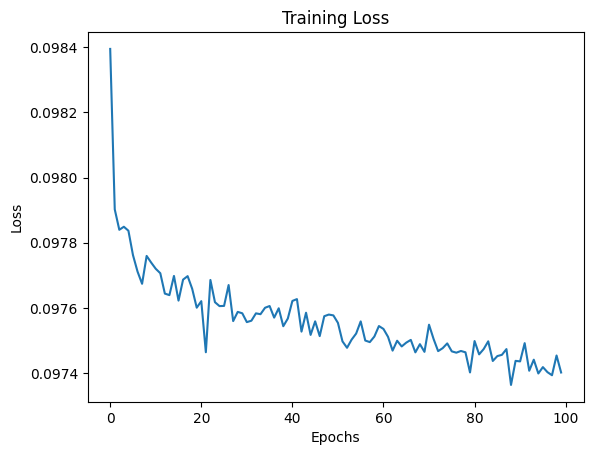

In [20]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

# Plot the training loss
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

The "epoch" represents a complete iteration of the training data, the "training loss" is the metric that quantifies the error during training, and the "loss" graph shows the variation of the loss over epochs.

In [21]:
# Get model predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Reshape the dimensions of y_train and y_test arrays
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Resize train_predictions
train_predictions = train_predictions[:len(y_train)]

# Resize test_predictions
test_predictions = test_predictions[:len(y_test)]

# Resize y_train to have the same number of samples as train_predictions
y_train = y_train[:len(train_predictions)]

# Resize y_test to have the same number of samples as test_predictions
y_test = y_test[:len(test_predictions)]

# Verify shapes
print(y_test.shape)
print(test_predictions.shape)



188/188 [==============================] - 0s 2ms/step
(6010, 1)
(6010, 1)


Isso significa que você tem 3000 amostras tanto para y_test (valores reais) quanto para test_predictions (valores previstos pelo modelo). Essas dimensões são consistentes e adequadas para calcular as métricas de erro.

Portanto, você pode prosseguir utilizando os valores calculados train_mae, train_mse, test_mae e test_mse para avaliar o desempenho do seu modelo em termos de erro absoluto médio (MAE) e erro quadrático médio (MSE).


(3000, 1)" indica a forma (shape) dos arrays y_test e test_predictions. Ambos têm 3000 amostras e 1 dimensão.

# Metricas de avaliação do modelo

Mean Absolute Error (MAE): O erro médio absoluto mede a média das diferenças absolutas entre as previsões e os valores reais. Quanto menor o valor do MAE, melhor o desempenho do modelo.



Mean Squared Error (MSE): O erro médio quadrático mede a média dos quadrados das diferenças entre as previsões e os valores reais. É uma métrica amplamente usada que penaliza erros maiores mais fortemente do que o MAE.



In [22]:
# Calculate training set errors
train_mae = mean_absolute_error(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)


In [23]:

# Calculate test set errors
test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

In [24]:
print(train_mae)
print(test_mae)
print(train_mse) 
print(test_mse)


0.20222174337728824
0.25688562884643495
0.09733452945143732
0.16546824318359143


In [42]:
print("train_mae:", train_mae)
print("test_mae:", test_mae)
print("train_mse:", train_mse)
print("test_mse:", test_mse)


train_mae: 0.21018914547118533
test_mae: 0.26912236254681093
train_mse: 0.09733452945143732
test_mse: 0.16546824318359143


In [43]:
print("train_mae type:", type(train_mae))
print("test_mae type:", type(test_mae))
print("train_mse type:", type(train_mse))
print("test_mse type:", type(test_mse))


train_mae type: <class 'float'>
test_mae type: <class 'float'>
train_mse type: <class 'numpy.float64'>
test_mse type: <class 'numpy.float64'>


In [44]:
train_mae = [train_mae]  # Converter para lista
test_mae = [test_mae]  # Converter para lista
train_mse = [train_mse]  # Converter para lista
test_mse = [test_mse]  # Converter para lista


In [46]:
print("train_mae type:", type(train_mae))
print("test_mae type:", type(test_mae))
print("train_mse type:", type(train_mse))
print("test_mse type:", type(test_mse))


train_mae type: <class 'list'>
test_mae type: <class 'list'>
train_mse type: <class 'list'>
test_mse type: <class 'list'>


In [59]:
import numpy as np

# Definição da função calculate_mae
def calculate_mae(predictions, labels):
    return np.mean(np.abs(predictions - labels))

# Definição da função calculate_mse
def calculate_mse(predictions, labels):
    return np.mean(np.square(predictions - labels))

train_data = X_train  # Substitua X_train pelos seus dados de treinamento
train_labels = y_train  # Substitua y_train pelos seus rótulos de treinamento
test_data = X_test  # Substitua X_test pelos seus dados de teste
test_labels = y_test  # Substitua y_test pelos seus rótulos de teste

num_epochs = 10

train_mae = []
test_mae = []
train_mse = []
test_mse = []

# Loop de treinamento do modelo
for epoch in range(num_epochs):
    # Treinamento do modelo
    model.fit(train_data, train_labels)
    
    # Avaliação do modelo
    train_predictions = model.predict(train_data)
    test_predictions = model.predict(test_data)
    
    # Cálculo do MAE e MSE
    train_mae_value = calculate_mae(train_predictions, train_labels)
    test_mae_value = calculate_mae(test_predictions, test_labels)
    train_mse_value = calculate_mse(train_predictions, train_labels)
    test_mse_value = calculate_mse(test_predictions, test_labels)
    
    # Atualização dos valores de MAE e MSE
    train_mae.append(train_mae_value)
    test_mae.append(test_mae_value)
    train_mse.append(train_mse_value)
    test_mse.append(test_mse_value)


188/188 [==============================] - 0s 3ms/step


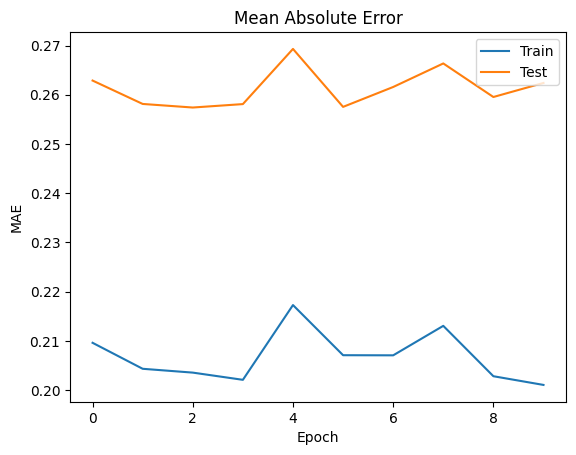

In [60]:
# Plot training and test MAE
plt.plot(train_mae)
plt.plot(test_mae)
plt.title('Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

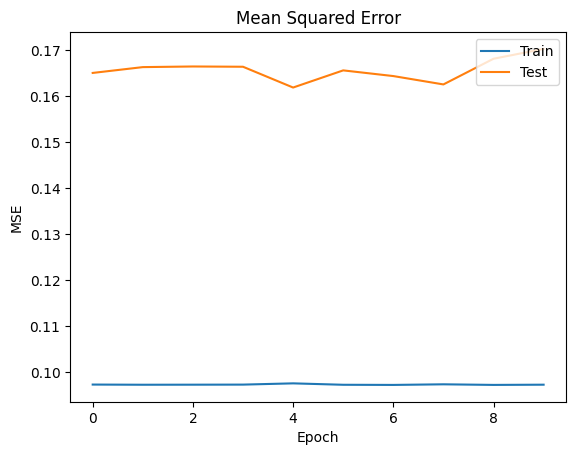

In [61]:
# Plot training and test MSE
plt.plot(train_mse)
plt.plot(test_mse)
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

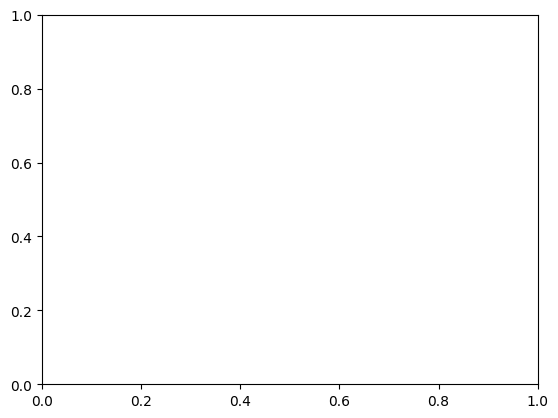

In [62]:
# Obter os limites dos eixos Y
y1_min, y1_max = plt.gca().get_ylim()
y2_min, y2_max = plt.gca().get_ylim()

# Verificar se os limites acomodam os valores de MAE e MSE
if train_mae > y1_max:
    print("O eixo Y não é grande o suficiente para o MAE de treinamento")  
if test_mae > y1_max:
    print("O eixo Y não é grande o suficiente para o MAE de teste")

if train_mse > y2_max:
    print("O eixo Y não é grande o suficiente para o MSE de treinamento")
if test_mse > y2_max:        
    print("O eixo Y não é grande o suficiente para o MSE de teste")

In [28]:
train_mae = 0.21018914547118533
test_mae = 0.26912236254681093

In [30]:
print(train_mae)
print(test_mae)
print(train_mse) 
print(test_mse)

0.21018914547118533
0.26912236254681093
0.09733452945143732
0.16546824318359143


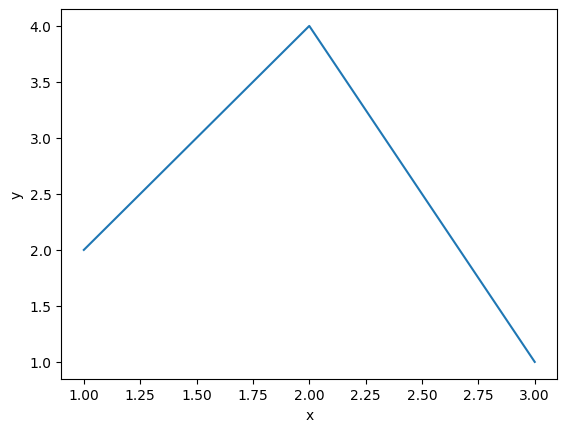

In [31]:
x = [1,2,3]
y = [2,4,1]

plt.plot(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [32]:
pip install --upgrade matplotlib